Bu notebook ağaç bazlı modellerin performanslarını karşılaştırmak ve bu spesifik görevde ne kadar iyi olduklarını ölçmek için oluşturulmuştur.

# Setup

In [ ]:
import os
import json

from tqdm import tqdm 

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.dates as mdates

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# PHASE 1: Load Data 

In [4]:
df = pd.read_csv(r"DATASETS\ForForecast.csv")
df['TransactionDateTime'] = pd.to_datetime(df['TransactionDateTime'])
df.set_index('TransactionDateTime', inplace=True)
df = df.sort_index()

print(f"Shape {df.shape}")
df.tail(10)

Shape (13499, 19)


ChannelKey  DataAreaKey InventKey InventLocationKey  \
TransactionDateTime                                                        
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:12:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   
2024-02-08 22:28:00           2            3    others            others   

                    CampaignKrcKey  SalesQuantity  SalesGrossAmount  \
TransactionDateTime                                                   
2024-02-08 22:12:00           6414            4.0            221.01   
2024-02-08 22:12:00           6414            1.0            127.51   
2024-02-08 22:12:00           6414            4.0            221.01   
2024-02-08 22:12:00           6414            1.0            127.52   
2024-02-08 22:12:00           6414            1.0            115.91   
2024-02-08 22:28:00            -99            1.0            110.49   
2024-02-08 22:28:00           6415            3.0            101.99   
2024-02-08 22:28:00              2            1.0            297.49   
2024-02-08 22:28:00            -99            1.0             84.99   
2024-02-08 22:28:00            -99            2.0            305.99   

                     Return_Quantity  NetQuantity  NetGrossAmount  \
TransactionDateTime                                                 
2024-02-08 22:12:00              0.0          4.0          221.01   
2024-02-08 22:12:00              0.0          1.0          127.51   
2024-02-08 22:12:00              0.0          4.0          221.01   
2024-02-08 22:12:00              0.0          1.0          127.52   
2024-02-08 22:12:00              0.0          1.0          115.91   
2024-02-08 22:28:00              0.0          1.0          110.49   
2024-02-08 22:28:00              0.0          3.0          101.99   
2024-02-08 22:28:00              0.0          1.0          297.49   
2024-02-08 22:28:00              0.0          1.0           84.99   
2024-02-08 22:28:00              0.0          2.0          305.99   

                     ReturnGrossAmount  ReturnNetAmount  NetAmountWOVat  \
TransactionDateTime                                                       
2024-02-08 22:12:00                0.0              0.0          184.17   
2024-02-08 22:12:00                0.0              0.0          106.26   
2024-02-08 22:12:00                0.0              0.0          184.17   
2024-02-08 22:12:00                0.0              0.0          106.27   
2024-02-08 22:12:00                0.0              0.0           96.59   
2024-02-08 22:28:00                0.0              0.0           92.07   
2024-02-08 22:28:00                0.0              0.0           84.99   
2024-02-08 22:28:00                0.0              0.0          270.45   
2024-02-08 22:28:00                0.0              0.0           70.83   
2024-02-08 22:28:00                0.0              0.0          254.99   

                     DiscountAmount  DiscountGrossAmount RboStoreKey  \
TransactionDateTime                                                    
2024-02-08 22:12:00          390.71               390.71      others   
2024-02-08 22:12:00          343.07               343.07      others   
2024-02-08 22:12:00          390.71               390.71      others   
2024-02-08 22:12:00          343.06               343.06      others   
2024-02-08 22:12:00          213.49               213.49      others   
2024-02-08 22:28:00  

In [5]:
df.dtypes

ChannelKey               int64
DataAreaKey              int64
InventKey               object
InventLocationKey       object
CampaignKrcKey          object
SalesQuantity          float64
SalesGrossAmount       float64
Return_Quantity        float64
NetQuantity            float64
NetGrossAmount         float64
ReturnGrossAmount      float64
ReturnNetAmount        float64
NetAmountWOVat         float64
DiscountAmount         float64
DiscountGrossAmount    float64
RboStoreKey             object
NetAmount              float64
HourIntervalKey          int64
IsFirstOrder              bool
dtype: object

# PHASE 2: Prepare Data

## Resample and fix

In [6]:
desired_column = 'NetAmountWOVat'

In [7]:
df = df[[desired_column]]

In [8]:
resampled_df = df.resample('60T', closed="left").sum()
print(resampled_df.shape)

(206, 1)


In [9]:
resampled_df.head(10)

NetAmountWOVat
TransactionDateTime                
2024-01-31 09:00:00         7444.94
2024-01-31 10:00:00        16321.85
2024-01-31 11:00:00        16112.86
2024-01-31 12:00:00         9955.61
2024-01-31 13:00:00        36883.48
2024-01-31 14:00:00        11374.87
2024-01-31 15:00:00        49252.87
2024-01-31 16:00:00        65630.39
2024-01-31 17:00:00        31425.66
2024-01-31 18:00:00        39486.80

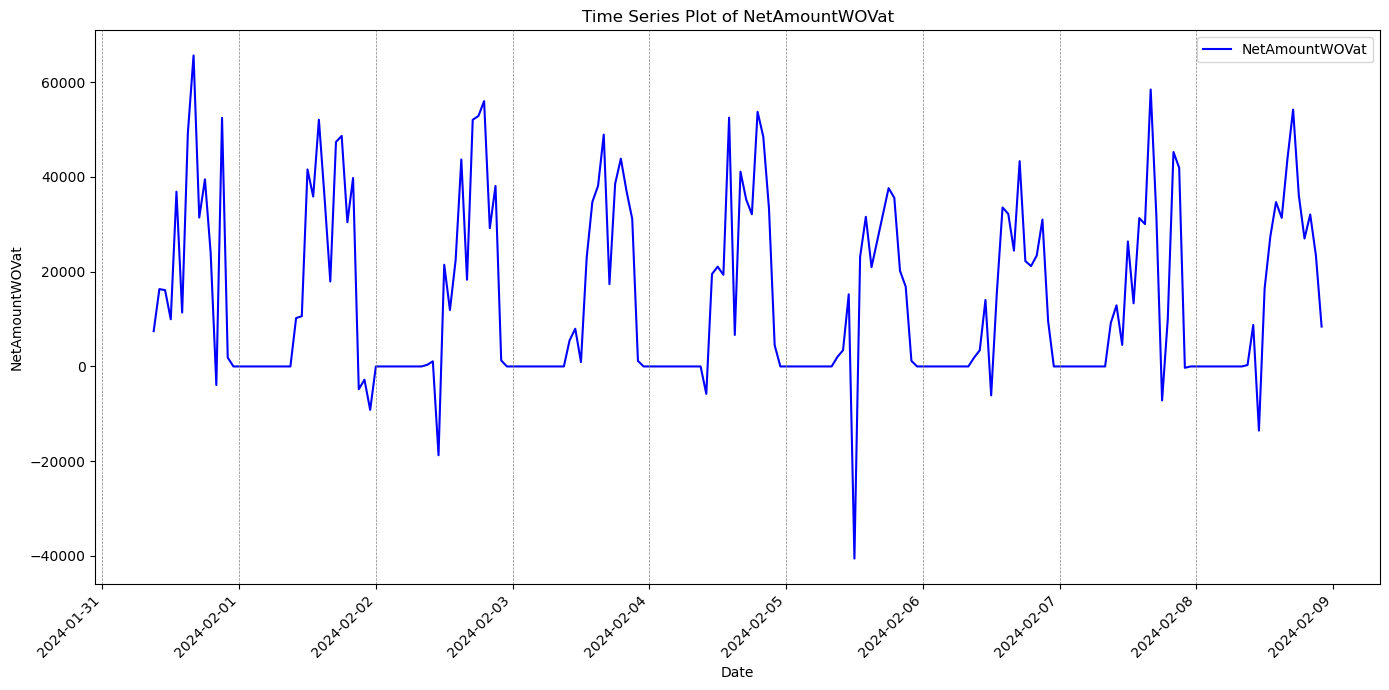

In [10]:
plt.figure(figsize=(14, 7))

plt.plot(resampled_df.index, resampled_df[f'{desired_column}'], label=f'{desired_column}', color='blue')

plt.xlabel('Date')
plt.ylabel(f'{desired_column}')
plt.title(f'Time Series Plot of {desired_column}')

plt.gca().xaxis.set_major_locator(mdates.DayLocator()) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 

plt.xticks(rotation=45, ha='right')

for date in np.unique(resampled_df.index.date):
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
Q1 = resampled_df[desired_column].quantile(0.25)
Q3 = resampled_df[desired_column].quantile(0.75)
IQR = Q3 - Q1

# Define threshold for outliers
lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1 * IQR

outliers = resampled_df[(resampled_df[desired_column] < lower_bound) | (resampled_df[desired_column] > upper_bound)]

resampled_df = resampled_df[(resampled_df[desired_column] >= lower_bound) & (resampled_df[desired_column] <= upper_bound)]

# Display information about removed outliers
print("Number of outliers removed:", len(outliers))
print("DataFrame size after removing outliers:", len(resampled_df))

Number of outliers removed: 2
DataFrame size after removing outliers: 204


In [12]:
"""
Bu notebook'un bir farkı ağaç modellerinin sekans şeklindeki verileri doğal oalrak işleyemediği için bunların suni bir şekilde "önceki 1, önceki 2" gibi
eklenmesi gerektiğidir.
Ayrıca ağaç modelleri mimarilerinin doğası gereği normalizasyon gerektirmez.
"""

sequence_length = 1

resampled_df["HourInterval"] = resampled_df.index.hour
resampled_df['DayOfWeek'] = resampled_df.index.dayofweek + 1
for i in range(1, sequence_length+1):
    resampled_df[f'{desired_column} Before {i}'] = resampled_df[f'{desired_column}'].shift(i)

resampled_df = resampled_df.dropna()

In [13]:
print(resampled_df.shape)
resampled_df.head()

(203, 4)


NetAmountWOVat  HourInterval  DayOfWeek  \
TransactionDateTime                                            
2024-01-31 10:00:00        16321.85            10          3   
2024-01-31 11:00:00        16112.86            11          3   
2024-01-31 12:00:00         9955.61            12          3   
2024-01-31 13:00:00        36883.48            13          3   
2024-01-31 14:00:00        11374.87            14          3   

                     NetAmountWOVat Before 1  
TransactionDateTime                           
2024-01-31 10:00:00                  7444.94  
2024-01-31 11:00:00                 16321.85  
2024-01-31 12:00:00                 16112.86  
2024-01-31 13:00:00                  9955.61  
2024-01-31 14:00:00                 36883.48

## Train-Test Split

In [14]:
train_ratio = 0.8
train_size = int(len(resampled_df) * train_ratio)

train_df = resampled_df[:train_size]
valid_df = resampled_df[train_size:]

In [15]:
print("Train size:", train_size, "Valid Size:", len(resampled_df) - train_size)

Train size: 162 Valid Size: 41


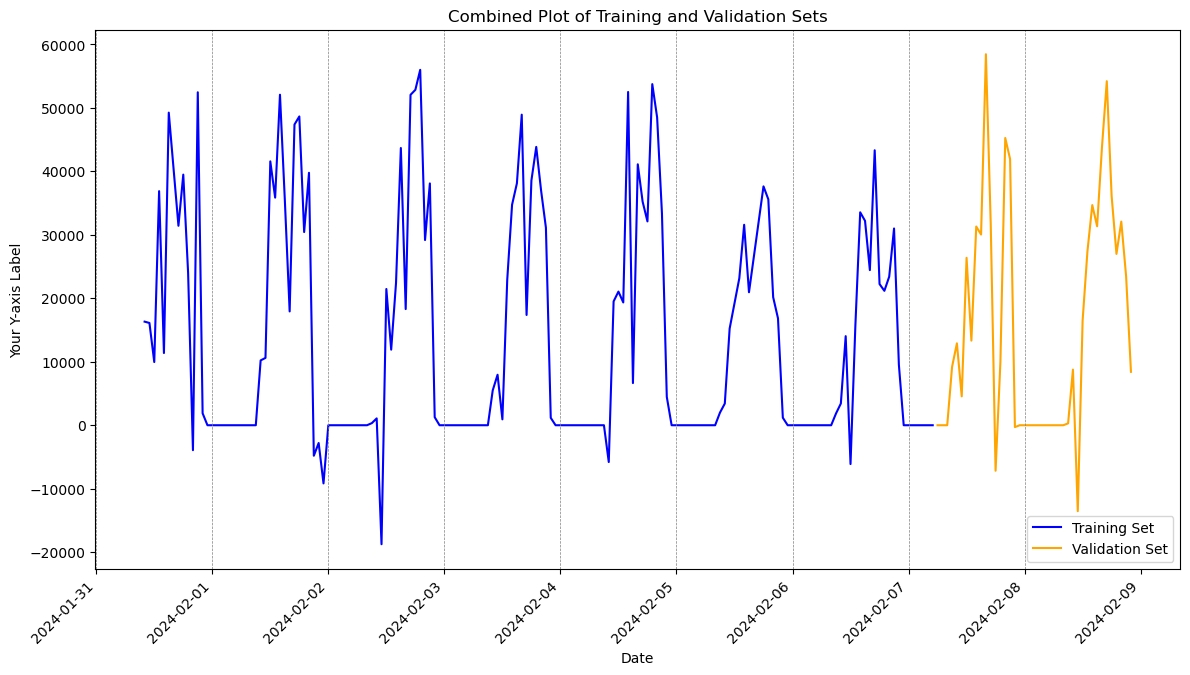

In [16]:
plt.figure(figsize=(14, 7))


plt.plot(train_df.index, train_df[f'{desired_column}'], label='Training Set', color='blue')
plt.plot(valid_df.index, valid_df[f'{desired_column}'], label='Validation Set', color='orange')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Your Y-axis Label')
plt.title('Combined Plot of Training and Validation Sets')

# Date formatting for better readability
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Adjust this based on your data frequency
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Adjust the date format as needed

# Rotate x-axis labels for skew
plt.xticks(rotation=45, ha='right')

# Add vertical dashed lines to separate days
for date in np.unique(resampled_df.index.date):
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()

## Datasets

In [17]:
import xgboost as xgb
import lightgbm as lgb

X_train, y_train = train_df.drop(columns=[desired_column]), train_df[desired_column]
X_valid, y_valid = valid_df.drop(columns=[desired_column]), valid_df[desired_column]

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Define the LightGBM dataset
ltrain = lgb.Dataset(X_train, label=y_train, feature_name='auto', categorical_feature='auto')
lvalid = lgb.Dataset(X_valid, label=y_valid, feature_name='auto', categorical_feature='auto', reference=ltrain)

In [18]:
X_valid

HourInterval  DayOfWeek  NetAmountWOVat Before 1
TransactionDateTime                                                  
2024-02-07 06:00:00             6          3                     0.00
2024-02-07 07:00:00             7          3                     0.00
2024-02-07 08:00:00             8          3                     0.00
2024-02-07 09:00:00             9          3                     0.00
2024-02-07 10:00:00            10          3                  9186.90
2024-02-07 11:00:00            11          3                 12900.58
2024-02-07 12:00:00            12          3                  4545.71
2024-02-07 13:00:00            13          3                 26380.39
2024-02-07 14:00:00            14          3                 13332.09
2024-02-07 15:00:00            15          3                 31310.19
2024-02-07 16:00:00            16          3                 30046.40
2024-02-07 17:00:00            17          3                 58455.45
2024-02-07 18:00:00            18          3                 31651.27
2024-02-07 19:00:00            19          3                 -7171.68
2024-02-07 20:00:00            20          3                 10000.07
2024-02-07 21:00:00            21          3                 45257.45
2024-02-07 22:00:00            22          3                 41939.75
2024-02-07 23:00:00            23          3                  -290.14
2024-02-08 00:00:00             0          4                     0.00
2024-02-08 01:00:00             1          4                     0.00
2024-02-08 02:00:00             2          4                     0.00
2024-02-08 03:00:00             3          4                     0.00
2024-02-08 04:00:00             4          4                     0.00
2024-02-08 05:00:00             5          4                     0.00
2024-02-08 06:00:00             6          4                     0.00
2024-02-08 07:00:00             7          4                     0.00
2024-02-08 08:00:00             8          4                     0.00
2024-02-08 09:00:00             9          4                     0.00
2024-02-08 10:00:00            10          4                   291.61
2024-02-08 11:00:00            11          4                  8764.06
2024-02-08 12:00:00            12          4                -13541.08
2024-02-08 13:00:00            13          4                 16478.08
2024-02-08 14:00:00            14          4                 27416.69
2024-02-08 15:00:00            15          4                 34684.19
2024-02-08 16:00:00            16          4                 31353.18
2024-02-08 17:00:00            17          4                 43761.77
2024-02-08 18:00:00            18          4                 54206.70
2024-02-08 19:00:00            19          4                 36130.63
2024-02-08 20:00:00            20          4                 26992.63
2024-02-08 21:00:00            21          4                 32083.99
2024-02-08 22:00:00            22          4                 23429.17

# PHASE 3: Training

Bu modellerin hepsi Scikit-learn kütüphanesinden ya da onun üzerine inşa edilmiş kütüphanelerden oluştukları için bu modelleri optimize etmek için GridSearchCV kullandım. Veri setinin büyüklüğüne göre eğitim aşaması oldukça yavaşlayabilir.

## Setup

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

## XGBoost

Extreme gradient boosting (XGB) kodu için aşağıda yapacağım açıklamalar özel bir durum olmadıkça diğer ağaç modelleri için de geçerlidir.

In [20]:
param_grid = {
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}

## model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=0)

## grid search objesi
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)

## grid search çalıştırma
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 6, 9], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [21]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}


In [22]:
params = {
    'booster': 'gbtree',  # 'gbtree', 'gblinear', 'dart'
    'silent': 0,          # 0 çıktı gösterir, 1 göstermez
    'nthread': -1         # Parallel işlem sayısı, -1 maksimum paralel işlem kullanır

}

# Booster parametreleri
params.update({
    'eta': 0.1,            # öğrenme hızı
    'max_depth': 3,        # ağaçların maksimum derinliği
    'subsample': 0.8,        # veri setinin ne kadarının rastgele tekrardan işleneceği oran
    'colsample_bytree': 0.8, # değişkenlerin ne kadarının rastgele tekrardan işleneceği oran
    'lambda': 1,           # L2 regularizasyonu
    'alpha': 0             # L1 regularizasyonu
})

# Öğrenme parametreleri
params.update({
    'objective': 'reg:squarederror',  # 'reg:squarederror', 'binary:logistic', vs.
    'eval_metric': 'rmse'              # değerlendirme fonksiyonu
})

# Ağaçlara özel parametreler
params.update({
    'gamma': 0,              # ağacın büyümesi için gerekli minimum hata katsayısı
    'min_child_weight': 3,   # dallarda gerekli minimum ağırlık sayısı
    'max_delta_step': 0      # ağırlık yakınsama hesabı için istenilen maksimum adım sayısı
})

# Eğitim parametreleri
params.update({
    'seed': 0,              # sonuçları tekrar elde edebilmek için
    'num_boost_round': 50  # kaç tur çalışması gerektiği
})

# model eğitimi
xgb_model = xgb.train(params, dtrain, num_boost_round=params['num_boost_round'], evals=[(dtrain, 'train'), (dvalid, 'valid')], early_stopping_rounds=10)

# model tahminleri
xgb_predictions = xgb_model.predict(dvalid)

# modeli değerlendirme
rmse = mean_squared_error(y_valid, xgb_predictions, squared=False)
print(f"Root Mean Squared Error on validation set: {rmse}")

[0]	train-rmse:16512.58923	valid-rmse:17063.52680
[1]	train-rmse:15392.73361	valid-rmse:16021.19053
[2]	train-rmse:14443.29903	valid-rmse:15191.22078
[3]	train-rmse:13590.89755	valid-rmse:14469.16732
[4]	train-rmse:12885.01571	valid-rmse:13898.61253
[5]	train-rmse:12288.26926	valid-rmse:13426.78212
[6]	train-rmse:11818.18470	valid-rmse:13147.16563
[7]	train-rmse:11409.32568	valid-rmse:12823.61101
[8]	train-rmse:11004.17780	valid-rmse:12505.94190
[9]	train-rmse:10643.98999	valid-rmse:12231.35985
[10]	train-rmse:10250.43995	valid-rmse:11922.15753
[11]	train-rmse:9953.74228	valid-rmse:11729.11256
[12]	train-rmse:9697.03410	valid-rmse:11620.84996
[13]	train-rmse:9492.20763	valid-rmse:11504.18906
[14]	train-rmse:9324.14215	valid-rmse:11510.10050
[15]	train-rmse:9111.10138	valid-rmse:11408.63835
[16]	train-rmse:8948.98817	valid-rmse:11382.50235
[17]	train-rmse:8872.72434	valid-rmse:11364.08076
[18]	train-rmse:8723.33860	valid-rmse:11319.07465
[19]	train-rmse:8627.24163	valid-rmse:11347.06586

## LightGBM

In [23]:
lgb_seed = 0

param_grid = {
    'num_leaves': [20, 31, 40],            # dal sayısı
    'learning_rate': [0.01, 0.05, 0.1],     # öğrenme hızı
    'subsample': [0.8, 0.9, 1.0],           # veri setinin ne kadarının rastgele tekrardan işleneceği oran
    'colsample_bytree': [0.8, 0.9, 1.0]     # değişkenlerin ne kadarının rastgele tekrardan işleneceği oran
}

lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse', boosting_type='gbdt', verbose=0, random_state=lgb_seed)

grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

lgb_model = grid_search.best_estimator_
lgb_pred = lgb_model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, lgb_pred))
print(f'Root Mean Squared Error on Validation Set: {rmse}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

## CatBoost

In [24]:
from catboost import CatBoostRegressor

catboost_param_grid = {
    'iterations': [500, 1000],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss_function': ['RMSE']
}

catboost_model = CatBoostRegressor(verbose=False)

catboost_grid_search = GridSearchCV(catboost_model, catboost_param_grid, cv=5, scoring='neg_mean_squared_error')

catboost_grid_search.fit(X_train, y_train)

best_catboost_params = catboost_grid_search.best_params_
cat_model = catboost_grid_search.best_estimator_
cat_pred = cat_model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, cat_pred))
print(f'Root Mean Squared Error on Validation Set: {rmse}')

Root Mean Squared Error on Validation Set: 11593.091520413003


In [25]:
import pickle

# Uygulama için kullanmak adına modeli kaydetme kısmı
with open(r'MODELS\catboost_model.pkl', 'wb') as f:
    pickle.dump(cat_model, f)

## Adaboost

In [26]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

base_model = DecisionTreeRegressor()
param_grid_base = {'max_depth': [3, 5, 7]}

grid_search_base = GridSearchCV(estimator=base_model, param_grid=param_grid_base, scoring='neg_mean_squared_error', cv=3)
grid_search_base.fit(X_train, y_train)

best_base_params = grid_search_base.best_params_

adaboost_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(**best_base_params), n_estimators=50, learning_rate=0.1)

param_grid_adaboost = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}

grid_search_adaboost = GridSearchCV(estimator=adaboost_model, param_grid=param_grid_adaboost, scoring='neg_mean_squared_error', cv=3)
grid_search_adaboost.fit(X_train, y_train)

best_adaboost_params = grid_search_adaboost.best_params_

ada_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(**best_base_params), **best_adaboost_params)

ada_model.fit(X_train, y_train)

ada_pred = ada_model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, ada_pred))
print(f'Root Mean Squared Error on Validation Set: {rmse}')

Root Mean Squared Error on Validation Set: 13024.136139768776


## Random Forest

In [27]:
rf_seed = 0

rf_model = RandomForestRegressor(random_state=rf_seed)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
rf_model = grid_search.best_estimator_

rf_predictions = rf_model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, rf_predictions))
r2 = r2_score(y_valid, rf_predictions)

print(f'Best Parameters: {best_params}')
print(f'Mean Squared Error (MSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Mean Squared Error (MSE): 11556.34
R-squared (R2): 0.59


# PHASE 4: Testing

## Plot inference

In [28]:
# Asıl değerler
actual_train_values = train_df[desired_column]
actual_valid_values = valid_df[desired_column]

# XGB
predicted_train_values_xgb = xgb_model.predict(dtrain)
predicted_valid_values_xgb = xgb_model.predict(dvalid)

# LGB
predicted_train_values_lgb = lgb_model.predict(X_train)
predicted_valid_values_lgb = lgb_model.predict(X_valid)

# Cat
predicted_train_values_cat = cat_model.predict(X_train)
predicted_valid_values_cat= cat_model.predict(X_valid)

# Ada
predicted_train_values_ada = ada_model.predict(X_train)
predicted_valid_values_ada= ada_model.predict(X_valid)

# RF
predicted_train_values_rf = rf_model.predict(X_train)
predicted_valid_values_rf = rf_model.predict(X_valid)

# Ensemble 
ensemble_train_predictions = (predicted_train_values_xgb + predicted_train_values_lgb + predicted_train_values_rf + predicted_train_values_cat + predicted_train_values_ada) / 5
ensemble_valid_predictions = (predicted_valid_values_xgb + predicted_valid_values_lgb + predicted_valid_values_rf + predicted_valid_values_cat + predicted_valid_values_ada) / 5

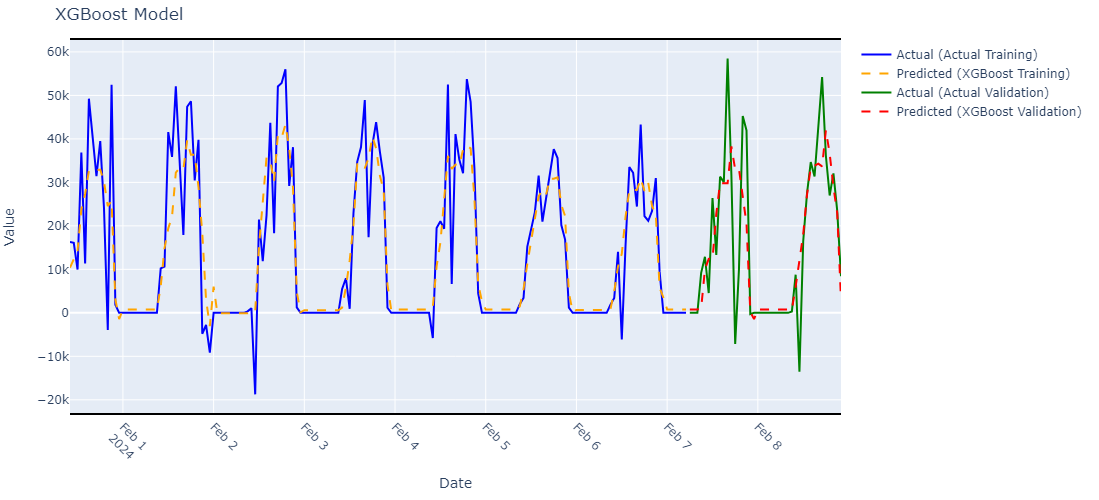

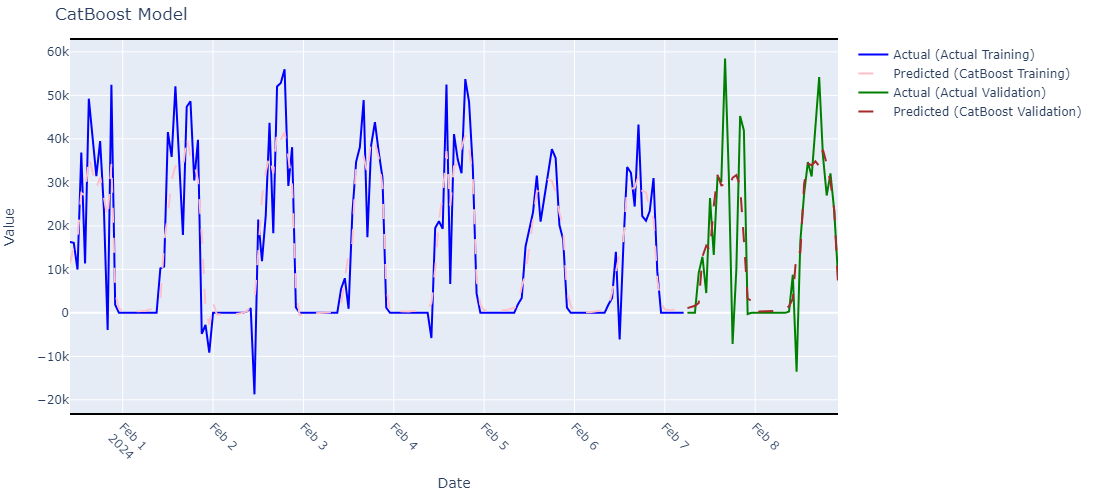

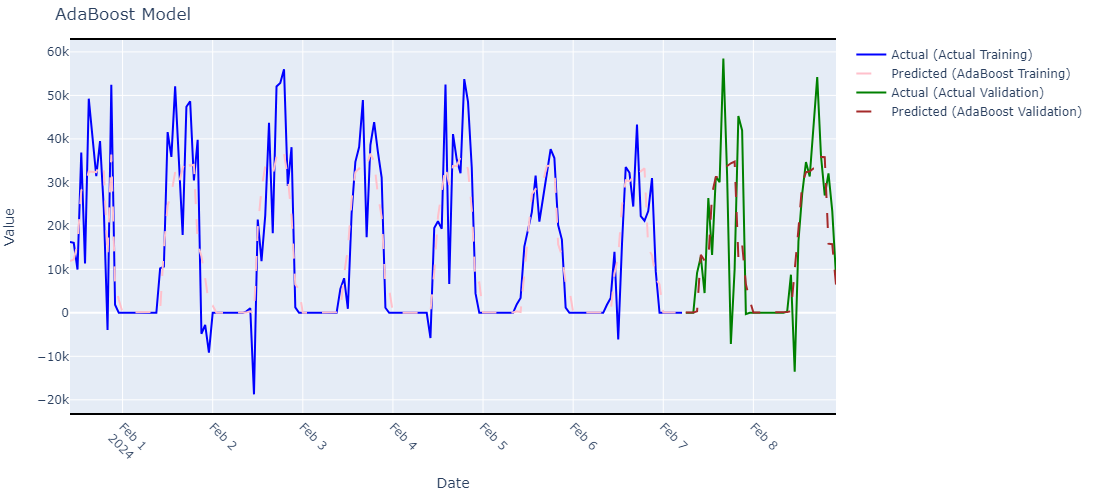

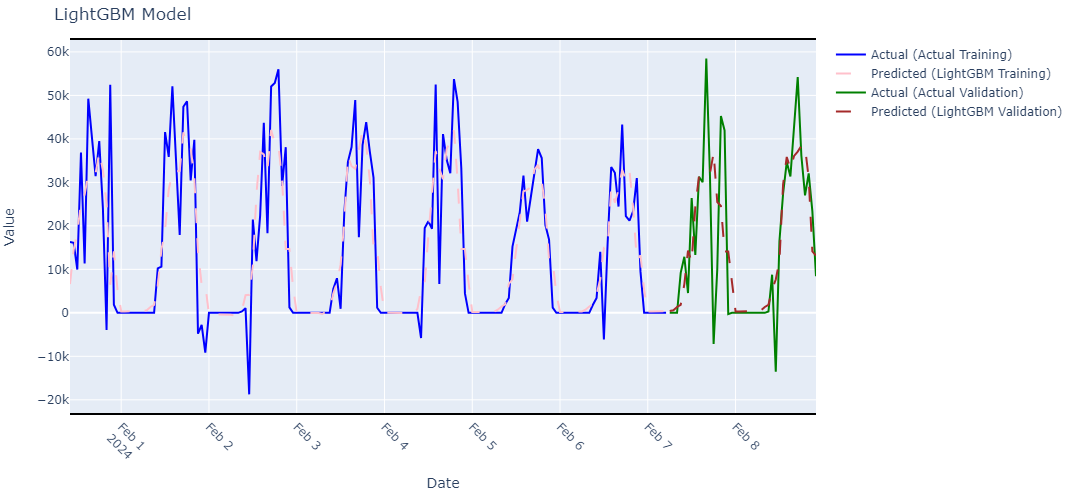

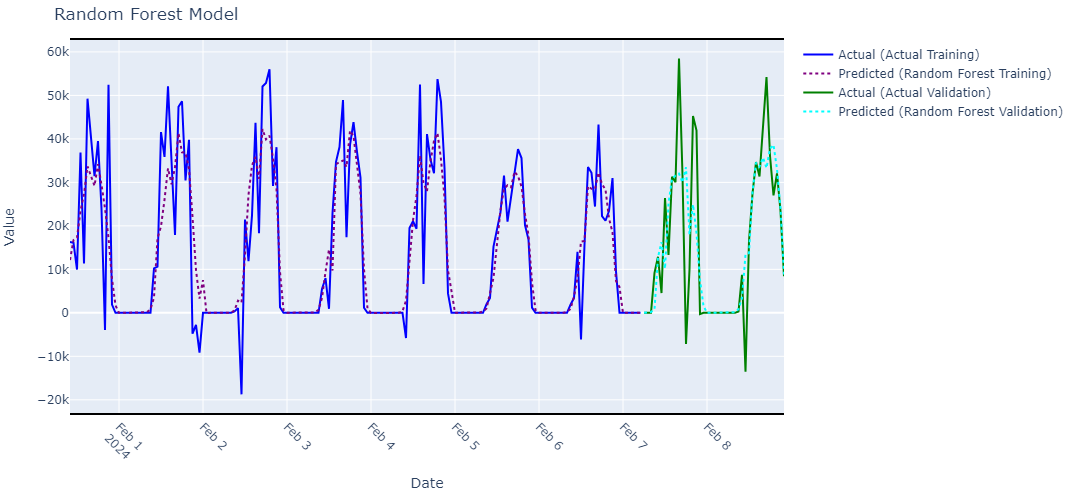

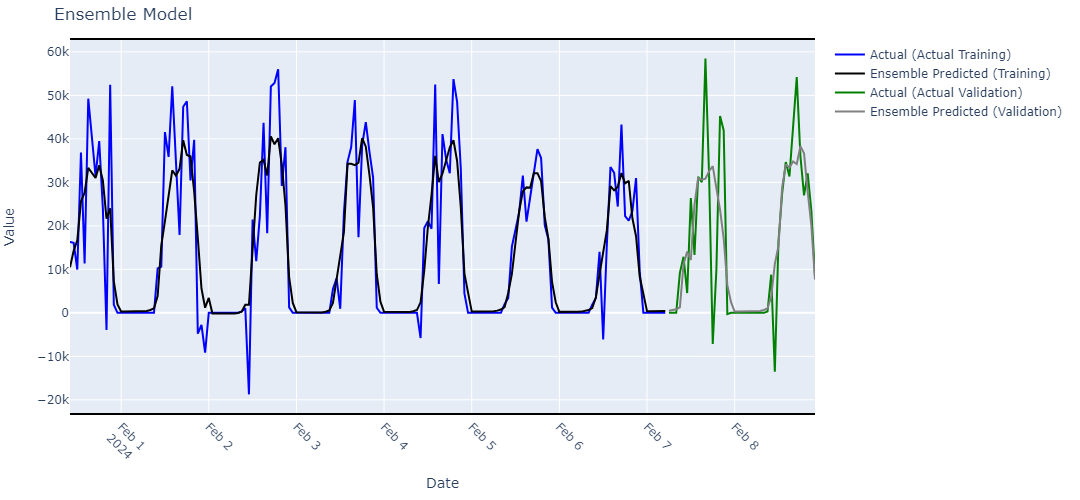

In [29]:
dates = resampled_df.index

# Asıl
trace_actual_train = go.Scatter(x=dates[:len(actual_train_values)], y=actual_train_values, mode='lines', name='Actual (Actual Training)', line=dict(color='blue'))
trace_actual_valid = go.Scatter(x=dates[-len(actual_valid_values):], y=actual_valid_values, mode='lines', name='Actual (Actual Validation)', line=dict(color='green'))

# XGBoost
trace_predicted_train_xgb = go.Scatter(x=dates[:len(predicted_train_values_xgb)], y=predicted_train_values_xgb, mode='lines', name='Predicted (XGBoost Training)', line=dict(color='orange', dash='dash'))
trace_predicted_valid_xgb = go.Scatter(x=dates[-len(predicted_valid_values_xgb):], y=predicted_valid_values_xgb, mode='lines', name='Predicted (XGBoost Validation)', line=dict(color='red', dash='dash'))

# LightGBM
trace_predicted_train_lgb = go.Scatter(x=dates[:len(predicted_train_values_lgb)], y=predicted_train_values_lgb, mode='lines', name='Predicted (LightGBM Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_lgb = go.Scatter(x=dates[-len(predicted_valid_values_lgb):], y=predicted_valid_values_lgb, mode='lines', name='Predicted (LightGBM Validation)', line=dict(color='brown', dash='longdash'))

# Catboost
trace_predicted_train_cat = go.Scatter(x=dates[:len(predicted_train_values_cat)], y=predicted_train_values_cat, mode='lines', name='Predicted (CatBoost Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_cat = go.Scatter(x=dates[-len(predicted_valid_values_cat):], y=predicted_valid_values_cat, mode='lines', name='Predicted (CatBoost Validation)', line=dict(color='brown', dash='longdash'))

# Adaoost
trace_predicted_train_ada = go.Scatter(x=dates[:len(predicted_train_values_ada)], y=predicted_train_values_ada, mode='lines', name='Predicted (AdaBoost Training)', line=dict(color='pink', dash='longdash'))
trace_predicted_valid_ada = go.Scatter(x=dates[-len(predicted_valid_values_ada):], y=predicted_valid_values_ada, mode='lines', name='Predicted (AdaBoost Validation)', line=dict(color='brown', dash='longdash'))

# Random Forest
trace_predicted_train_rf = go.Scatter(x=dates[:len(predicted_train_values_rf)], y=predicted_train_values_rf, mode='lines', name='Predicted (Random Forest Training)', line=dict(color='purple', dash='dot'))
trace_predicted_valid_rf = go.Scatter(x=dates[-len(predicted_valid_values_rf):], y=predicted_valid_values_rf, mode='lines', name='Predicted (Random Forest Validation)', line=dict(color='cyan', dash='dot'))

# Ensemble
trace_train_ensemble = go.Scatter(x=dates[:len(ensemble_train_predictions)], y=ensemble_train_predictions, mode='lines', name='Ensemble Predicted (Training)', line=dict(color='black', dash='solid'))
trace_valid_ensemble = go.Scatter(x=dates[-len(ensemble_valid_predictions):], y=ensemble_valid_predictions, mode='lines', name='Ensemble Predicted (Validation)', line=dict(color='gray', dash='solid'))

layout_xgb = go.Layout(
    title='XGBoost Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_lgb = go.Layout(
    title='LightGBM Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_cat = go.Layout(
    title='CatBoost Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_ada = go.Layout(
    title='AdaBoost Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_rf = go.Layout(
    title='Random Forest Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

layout_ensemble = go.Layout(
    title='Ensemble Model',
    xaxis=dict(title='Date', tickangle=45, showline=True, linewidth=2, linecolor='black', mirror=True),
    yaxis=dict(title='Value'),
    height=500, 
    width=1100,
    margin=dict(l=40, r=40, b=40, t=40)
)

fig_xgb = go.Figure(data=[trace_actual_train, trace_predicted_train_xgb, trace_actual_valid, trace_predicted_valid_xgb], layout=layout_xgb)
fig_lgb = go.Figure(data=[trace_actual_train, trace_predicted_train_lgb, trace_actual_valid, trace_predicted_valid_lgb], layout=layout_lgb)
fig_cat = go.Figure(data=[trace_actual_train, trace_predicted_train_cat, trace_actual_valid, trace_predicted_valid_cat], layout=layout_cat)
fig_ada = go.Figure(data=[trace_actual_train, trace_predicted_train_ada, trace_actual_valid, trace_predicted_valid_ada], layout=layout_ada)
fig_rf = go.Figure(data=[trace_actual_train, trace_predicted_train_rf, trace_actual_valid, trace_predicted_valid_rf], layout=layout_rf)
fig_ensemble = go.Figure(data=[trace_actual_train, trace_train_ensemble, trace_actual_valid, trace_valid_ensemble], layout=layout_ensemble)

fig_xgb.show()
fig_cat.show()
fig_ada.show()
fig_lgb.show()
fig_rf.show()
fig_ensemble.show()

In [30]:
predictions_train_df = pd.DataFrame({
    'Date': train_df.index,
    f'Actual {desired_column}': actual_train_values,
    f'XGB Predicted {desired_column}': predicted_train_values_xgb,
    f'LGB Predicted {desired_column}': predicted_train_values_lgb,
    f'CAT Predicted {desired_column}': predicted_train_values_cat,
    f'ADA Predicted {desired_column}': predicted_train_values_ada,
    f'RF Predicted {desired_column}': predicted_train_values_rf,
    f'Ensemble Predicted {desired_column}': ensemble_train_predictions
})

predictions_valid_df = pd.DataFrame({
    'Date': valid_df.index,
    f'Actual {desired_column}': actual_valid_values,
    f'XGB Predicted {desired_column}': predicted_valid_values_xgb,
    f'LGB Predicted {desired_column}': predicted_valid_values_lgb,
    f'CAT Predicted {desired_column}': predicted_valid_values_cat,
    f'ADA Predicted {desired_column}': predicted_valid_values_ada,
    f'RF Predicted {desired_column}': predicted_valid_values_rf,
    f'Ensemble Predicted {desired_column}': ensemble_valid_predictions
})

predictions_all_df = pd.concat([predictions_train_df, predictions_valid_df], ignore_index=True)
predictions_all_df.set_index('Date', inplace=True)

result_df = predictions_all_df.copy()
result_df.tail(10)

Actual NetAmountWOVat  XGB Predicted NetAmountWOVat  \
Date                                                                       
2024-02-08 13:00:00               27416.69                  27101.617188   
2024-02-08 14:00:00               34684.19                  33543.484375   
2024-02-08 15:00:00               31353.18                  33845.253906   
2024-02-08 16:00:00               43761.77                  34321.437500   
2024-02-08 17:00:00               54206.70                  33671.054688   
2024-02-08 18:00:00               36130.63                  41979.363281   
2024-02-08 19:00:00               26992.63                  36655.750000   
2024-02-08 20:00:00               32083.99                  28907.171875   
2024-02-08 21:00:00               23429.17                  22941.138672   
2024-02-08 22:00:00                8413.79                   3013.677979   

                     LGB Predicted NetAmountWOVat  \
Date                                                
2024-02-08 13:00:00                  29548.045968   
2024-02-08 14:00:00                  35841.481721   
2024-02-08 15:00:00                  33147.015665   
2024-02-08 16:00:00                  36087.138233   
2024-02-08 17:00:00                  37090.155682   
2024-02-08 18:00:00                  38423.638347   
2024-02-08 19:00:00                  38111.037684   
2024-02-08 20:00:00                  30999.389432   
2024-02-08 21:00:00                  14128.330262   
2024-02-08 22:00:00                  13143.423251   

                     CAT Predicted NetAmountWOVat  \
Date                                                
2024-02-08 13:00:00                  29722.745690   
2024-02-08 14:00:00                  34302.036267   
2024-02-08 15:00:00                  33952.402078   
2024-02-08 16:00:00                  34840.656605   
2024-02-08 17:00:00                  33771.341265   
2024-02-08 18:00:00                  37530.878580   
2024-02-08 19:00:00                  34222.668020   
2024-02-08 20:00:00                  30092.417436   
2024-02-08 21:00:00                  23620.298724   
2024-02-08 22:00:00                   6864.609820   

                     ADA Predicted NetAmountWOVat  \
Date                                                
2024-02-08 13:00:00                  29662.742069   
2024-02-08 14:00:00                  32345.611765   
2024-02-08 15:00:00                  32527.559524   
2024-02-08 16:00:00                  33214.566912   
2024-02-08 17:00:00                  33214.566912   
2024-02-08 18:00:00                  35861.902105   
2024-02-08 19:00:00                  35792.171017   
2024-02-08 20:00:00                  15904.293171   
2024-02-08 21:00:00                  15781.738125   
2024-02-08 22:00:00                   6492.731250   

                     RF Predicted NetAmountWOVat  \
Date                                               
2024-02-08 13:00:00                 27858.181131   
2024-02-08 14:00:00                 34520.670548   
2024-02-08 15:00:00                 33620.811558   
2024-02-08 16:00:00                 35697.374278   
2024-02-08 17:00:00                 33295.405763   
2024-02-08 18:00:00                 37775.394364   
2024-02-08 19:00:00                 38620.894744   
2024-02-08 20:00:00                 33083.503190   
2024-02-08 21:00:00                 24072.493783   
2024-02-08 22:00:00                  8797.617903   

                     Ensemble Predicted NetAmountWOVat  
Date                                                    
2024-02-08 13:00:00                       28778.666409  
2024-02-08 14:00:00                       34110.656935  
2024-02-08 15:00:00                       33418.608546  
2024-02-08 16:00:00                       34832.234706  
2024-02-08 17:00:00                       34208.504862  
2024-02-08 18:00:00                       38314.235336  
2024-02-08 19:00:00                       36680.504293  
2024-02-08 20:00:00                       27797.355021  
20

## Table Inference

In [31]:
result_df["Original_Status"] = np.where(result_df[f"Actual {desired_column}"].shift(-1) > result_df[f"Actual {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_XGBoost"] = np.where(result_df[f"XGB Predicted {desired_column}"].shift(-1) > result_df[f"XGB Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_LGB"] = np.where(result_df[f"LGB Predicted {desired_column}"].shift(-1) > result_df[f"LGB Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_CAT"] = np.where(result_df[f"CAT Predicted {desired_column}"].shift(-1) > result_df[f"CAT Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_ADA"] = np.where(result_df[f"ADA Predicted {desired_column}"].shift(-1) > result_df[f"ADA Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Predicted_Status_RF"] = np.where(result_df[f"RF Predicted {desired_column}"].shift(-1) > result_df[f"RF Predicted {desired_column}"], "Will Rise", "Will Fall")
result_df["Ensemble_Status"] = np.where(result_df[f"Ensemble Predicted {desired_column}"].shift(-1) > result_df[f"Ensemble Predicted {desired_column}"], "Will Rise", "Will Fall")

result_df.tail(40)

Actual NetAmountWOVat  XGB Predicted NetAmountWOVat  \
Date                                                                       
2024-02-07 07:00:00                   0.00                    784.482483   
2024-02-07 08:00:00                   0.00                    784.482483   
2024-02-07 09:00:00                9186.90                   1051.988403   
2024-02-07 10:00:00               12900.58                  10003.110352   
2024-02-07 11:00:00                4545.71                  12418.753906   
2024-02-07 12:00:00               26380.39                  12359.539062   
2024-02-07 13:00:00               13332.09                  22741.642578   
2024-02-07 14:00:00               31310.19                  29831.027344   
2024-02-07 15:00:00               30046.40                  29803.949219   
2024-02-07 16:00:00               58455.45                  29803.949219   
2024-02-07 17:00:00               31651.27                  38267.914062   
2024-02-07 18:00:00               -7171.68                  32944.296875   
2024-02-07 19:00:00               10000.07                  33105.894531   
2024-02-07 20:00:00               45257.45                  27179.367188   
2024-02-07 21:00:00               41939.75                  20469.457031   
2024-02-07 22:00:00                -290.14                    263.121704   
2024-02-07 23:00:00                   0.00                  -1453.203613   
2024-02-08 00:00:00                   0.00                    741.025574   
2024-02-08 01:00:00                   0.00                    741.025574   
2024-02-08 02:00:00                   0.00                    741.025574   
2024-02-08 03:00:00                   0.00                    741.025574   
2024-02-08 04:00:00                   0.00                    741.025574   
2024-02-08 05:00:00                   0.00                    741.025574   
2024-02-08 06:00:00                   0.00                    741.025574   
2024-02-08 07:00:00                   0.00                    741.025574   
2024-02-08 08:00:00                   0.00                    741.025574   
2024-02-08 09:00:00                 291.61                    741.025574   
2024-02-08 10:00:00                8764.06                   6032.794434   
2024-02-08 11:00:00              -13541.08                  11664.069336   
2024-02-08 12:00:00               16478.08                  18071.832031   
2024-02-08 13:00:00               27416.69                  27101.617188   
2024-02-08 14:00:00               34684.19                  33543.484375   
2024-02-08 15:00:00               31353.18                  33845.253906   
2024-02-08 16:00:00               43761.77                  34321.437500   
2024-02-08 17:00:00               54206.70                  33671.054688   
2024-02-08 18:00:00               36130.63                  41979.363281   
2024-02-08 19:00:00               26992.63                  36655.750000   
2024-02-08 20:00:00               32083.99                  28907.171875   
2024-02-08 21:00:00               23429.17                  22941.138672   
2024-02-08 22:00:00                8413.79                   3013.677979   

                     LGB Predicted NetAmountWOVat  \
Date                                                
2024-02-07 07:00:00                    588.992593   
2024-02-07 08:00:00                   1341.318472   
2024-02-07 09:00:00                   1847.327968   
2024-02-07 10:00:00                   6612.240292   
2024-02-07 11:00:00                  14327.129342   
2024-02-07 12:00:00                  11734.881086   
2024-02-07 13:00:00                  24434.842009   
2024-02-07 14:00:00                  31373.982758   
2024-02-07 15:00:00                  31043.252918   
2024-02-07 16:00:00                  31221.832685   
2024-02-07 17:00:00                  32046.270367   
2024-02-07 18:00:00                  36815.196787   
2024-02-07 19:00:00                  25480.982715   
2024-02-07 20:00:00              

In [32]:
real_values = result_df[f'Actual {desired_column}'].sum()
xgb_values = result_df[f'XGB Predicted {desired_column}'].sum()
lgb_values = result_df[f'LGB Predicted {desired_column}'].sum()
cat_values = result_df[f'CAT Predicted {desired_column}'].sum()
ada_values = result_df[f'ADA Predicted {desired_column}'].sum()
rf_values = result_df[f'RF Predicted {desired_column}'].sum()
ensemble_values = result_df[f'Ensemble Predicted {desired_column}'].sum()

print(f"Real {desired_column}:", real_values)
print(f"XGBoost {desired_column}:", xgb_values)
print(f"LightGBM {desired_column}:", lgb_values)
print(f"CatBoost {desired_column}:", cat_values)
print(f"AdaBoost {desired_column}:", ada_values)
print(f"Random Forest {desired_column}:", rf_values)
print(f"Ensemble {desired_column}:", ensemble_values)

print("-------------------------------------------")

print("The prediction offness:")
print("XGBoost:", int(xgb_values - real_values))
print("LightGBM:", int(lgb_values - real_values))
print("CatBoost:", int(cat_values - real_values))
print("AdaBoost:", int(ada_values - real_values))
print("Random Forest:", int(rf_values - real_values))
print("Ensemble:", int(ensemble_values - real_values))

Real NetAmountWOVat: 2832452.57
XGBoost NetAmountWOVat: 2824087.2
LightGBM NetAmountWOVat: 2840765.6875872365
CatBoost NetAmountWOVat: 2829349.7581564225
AdaBoost NetAmountWOVat: 2714524.2286539814
Random Forest NetAmountWOVat: 2826094.4085629038
Ensemble NetAmountWOVat: 2806964.2811276317
-------------------------------------------
The prediction offness:
XGBoost: -8365
LightGBM: 8313
CatBoost: -3102
AdaBoost: -117928
Random Forest: -6358
Ensemble: -25488


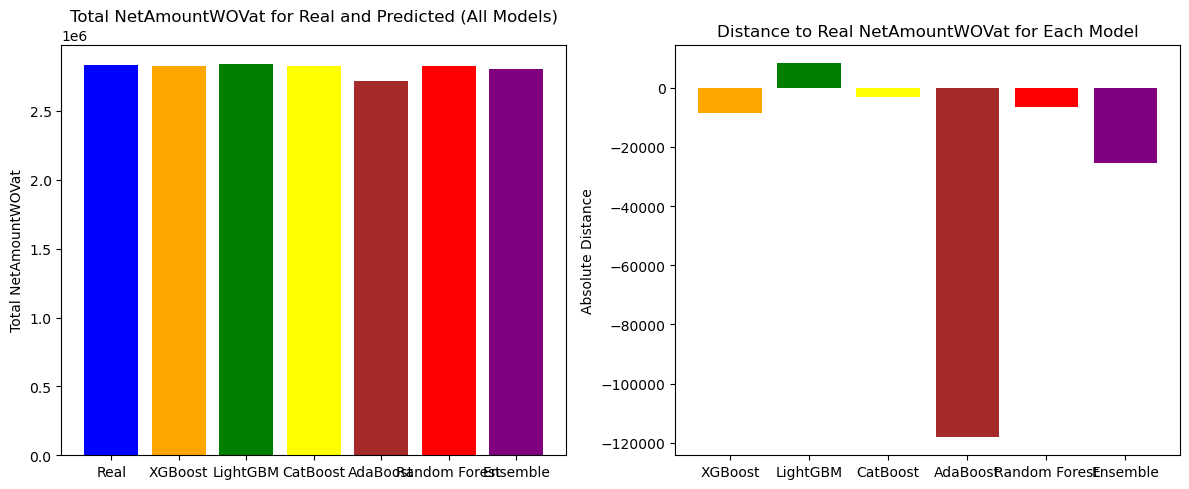

In [33]:
distance_xgb = xgb_values - real_values
distance_lgb = lgb_values - real_values
distance_cat = cat_values - real_values
distance_ada = ada_values - real_values
distance_rf = rf_values - real_values
distance_ensemble = ensemble_values - real_values

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(['Real', 'XGBoost', 'LightGBM', 'CatBoost', 'AdaBoost', 'Random Forest', 'Ensemble'],
            [real_values, xgb_values, lgb_values, cat_values, ada_values, rf_values, ensemble_values],
            color=['blue', 'orange', 'green', 'yellow', 'brown', 'red', 'purple'])
axes[0].set_title(f'Total {desired_column} for Real and Predicted (All Models)')
axes[0].set_ylabel(f'Total {desired_column}')

axes[1].bar(['XGBoost', 'LightGBM', 'CatBoost', 'AdaBoost', 'Random Forest', 'Ensemble'],
            [distance_xgb, distance_lgb, distance_cat, distance_ada, distance_rf, distance_ensemble],
            color=['orange', 'green', 'yellow', 'brown', 'red', 'purple'])
axes[1].set_title(f'Distance to Real {desired_column} for Each Model')
axes[1].set_ylabel('Absolute Distance')

plt.tight_layout()
plt.show()

# PHASE 5: Forecasting

## Prepare the emtpy set

In [34]:
start_timestamp = '2024-02-08 22:00:00'
end_timestamp = '2024-02-18 23:00:00'

forecast_timestamps = pd.date_range(start=start_timestamp, end=end_timestamp, freq='H')

forecast_df = pd.DataFrame(index=forecast_timestamps)

forecast_df[f'Forecasted {desired_column}'] = np.nan

forecast_df["HourInterval"] = forecast_df.index.hour
forecast_df['DayOfWeek'] = forecast_df.index.dayofweek + 1

for i in range(1, sequence_length+1):
    forecast_df[f'{desired_column} Before {i}'] = np.nan

forecast_df.head(4)

Forecasted NetAmountWOVat  HourInterval  DayOfWeek  \
2024-02-08 22:00:00                        NaN            22          4   
2024-02-08 23:00:00                        NaN            23          4   
2024-02-09 00:00:00                        NaN             0          5   
2024-02-09 01:00:00                        NaN             1          5   

                     NetAmountWOVat Before 1  
2024-02-08 22:00:00                      NaN  
2024-02-08 23:00:00                      NaN  
2024-02-09 00:00:00                      NaN  
2024-02-09 01:00:00                      NaN

In [35]:
forecast_df.iloc[:sequence_length] = valid_df.iloc[-sequence_length:]

for i in range(1, sequence_length+1):
    forecast_df.iloc[i, forecast_df.columns.get_loc(f'{desired_column} Before {i}')] = forecast_df.iloc[i-1][f'Forecasted {desired_column}']

In [36]:
print(forecast_df.shape)
forecast_df.head(6)

(242, 4)


Forecasted NetAmountWOVat  HourInterval  DayOfWeek  \
2024-02-08 22:00:00                    8413.79            22          4   
2024-02-08 23:00:00                        NaN            23          4   
2024-02-09 00:00:00                        NaN             0          5   
2024-02-09 01:00:00                        NaN             1          5   
2024-02-09 02:00:00                        NaN             2          5   
2024-02-09 03:00:00                        NaN             3          5   

                     NetAmountWOVat Before 1  
2024-02-08 22:00:00                 23429.17  
2024-02-08 23:00:00                  8413.79  
2024-02-09 00:00:00                      NaN  
2024-02-09 01:00:00                      NaN  
2024-02-09 02:00:00                      NaN  
2024-02-09 03:00:00                      NaN

## Forecasts

In [37]:
xgb_forecast_df = forecast_df.copy()
lgb_forecast_df = forecast_df.copy()
cat_forecast_df = forecast_df.copy()
ada_forecast_df = forecast_df.copy()
rf_forecast_df = forecast_df.copy()

In [38]:
features = ['HourInterval', 'DayOfWeek']
for i in range(1, sequence_length+1):
    features.append( f'{desired_column} Before {i}')

############################## XGBoost ###########################################
for i in range(sequence_length, len(forecast_df) + 100):
    input_array = lgb_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])
    input_dmatrix = xgb.DMatrix(data=input_df)

    predicted_value = xgb_model.predict(input_dmatrix)

    xgb_forecast_df.iloc[i, xgb_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    if xgb_forecast_df.isnull().sum()[0] == 0:
        break
        
    for k in range(1, sequence_length+1):
        xgb_forecast_df.iloc[i + k, xgb_forecast_df.columns.get_loc(f'{desired_column} Before {k}')] = xgb_forecast_df.iloc[i+1-k, xgb_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

############################## LightGBM ##########################################
for i in range(sequence_length, len(forecast_df) + 100):
    input_array = lgb_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    predicted_value = lgb_model.predict(input_df)

    lgb_forecast_df.iloc[i, lgb_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    if lgb_forecast_df.isnull().sum()[0] == 0:
        break

    for k in range(1, sequence_length+1):
        lgb_forecast_df.iloc[i + k, lgb_forecast_df.columns.get_loc(f'{desired_column} Before {k}')] = lgb_forecast_df.iloc[i+1-k, lgb_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

############################## CatBoost ################################
for i in range(sequence_length, len(forecast_df) + 100):
    input_array = cat_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    predicted_value = cat_model.predict(input_df)

    cat_forecast_df.iloc[i, cat_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    if cat_forecast_df.isnull().sum()[0] == 0:
        break

    for k in range(1, sequence_length+1):
        cat_forecast_df.iloc[i + k, cat_forecast_df.columns.get_loc(f'{desired_column} Before {k}')] = cat_forecast_df.iloc[i+1-k, cat_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]
        
############################## AdaBoost ################################
for i in range(sequence_length, len(forecast_df) + 100):
    input_array = ada_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    predicted_value = ada_model.predict(input_df)

    ada_forecast_df.iloc[i, ada_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    if ada_forecast_df.isnull().sum()[0] == 0:
        break

    for k in range(1, sequence_length+1):
        ada_forecast_df.iloc[i + k, ada_forecast_df.columns.get_loc(f'{desired_column} Before {k}')] = ada_forecast_df.iloc[i+1-k, ada_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]
        
############################## Random Forest ################################
for i in range(sequence_length, len(forecast_df) + 100):
    input_array = rf_forecast_df[features].iloc[i]
    input_df = pd.DataFrame([input_array])

    predicted_value = rf_model.predict(input_df)

    rf_forecast_df.iloc[i, rf_forecast_df.columns.get_loc(f'Forecasted {desired_column}')] = predicted_value.item()

    if rf_forecast_df.isnull().sum()[0] == 0:
        break

    for k in range(1, sequence_length+1):
        rf_forecast_df.iloc[i + k, rf_forecast_df.columns.get_loc(f'{desired_column} Before {k}')] = rf_forecast_df.iloc[i+1-k, rf_forecast_df.columns.get_loc(f'Forecasted {desired_column}')]

############################## Ensemble ################################
ensemble_forecast_df = pd.DataFrame()
ensemble_forecast_df[f'Forecasted {desired_column}'] = (xgb_forecast_df[f'Forecasted {desired_column}'] + lgb_forecast_df[f'Forecasted {desired_column}']
+ cat_forecast_df[f'Forecasted {desired_column}'] + ada_forecast_df[f'Forecasted {desired_column}'] + rf_forecast_df[f'Forecasted {desired_column}']) / 5

## Plot Inference

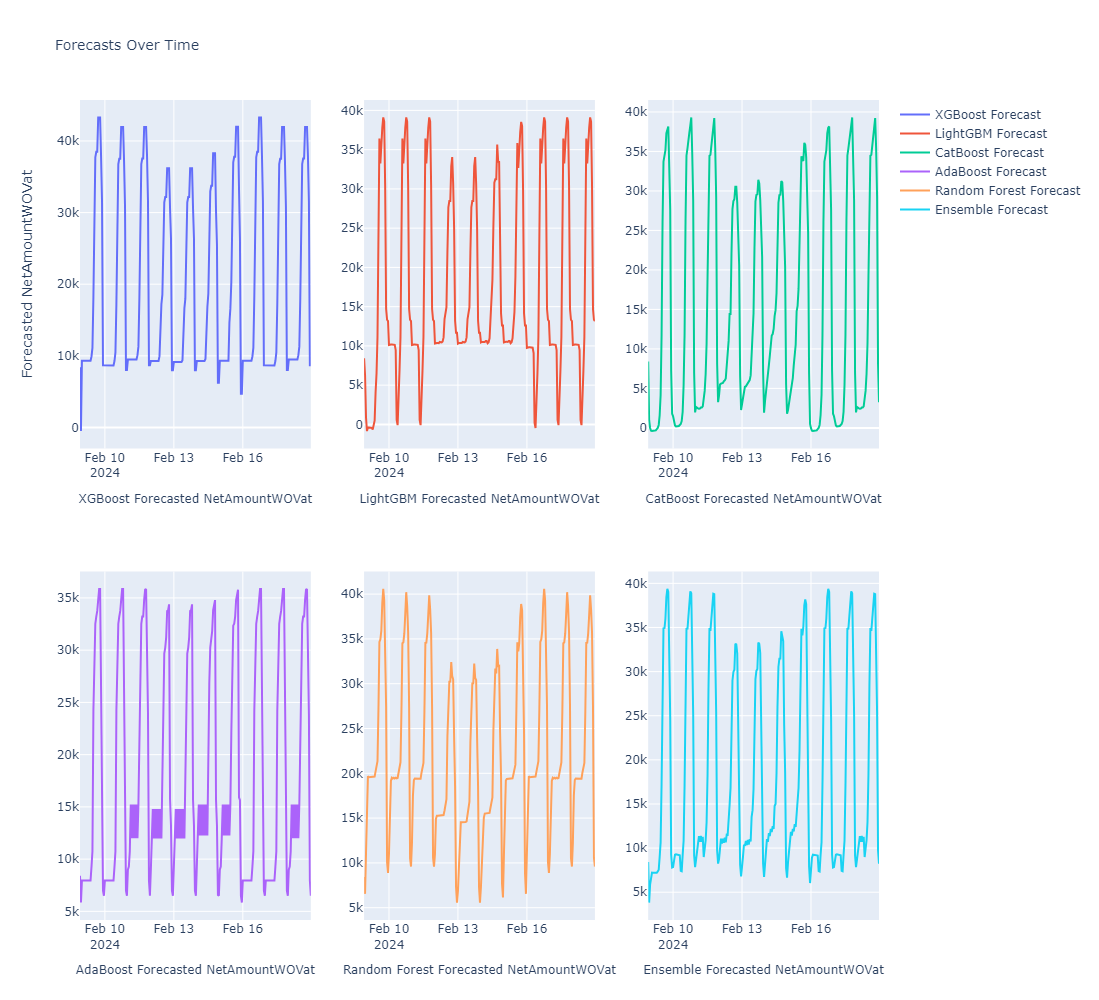

In [39]:
import plotly.subplots as sp
import plotly.graph_objects as go

fig = sp.make_subplots(rows=2, cols=3)

# XGBoost
fig.add_trace(go.Scatter(x=xgb_forecast_df.index, y=xgb_forecast_df[f'Forecasted {desired_column}'], mode='lines', name='XGBoost Forecast'), row=1, col=1)

# LightGBM
fig.add_trace(go.Scatter(x=lgb_forecast_df.index, y=lgb_forecast_df[f'Forecasted {desired_column}'], mode='lines', name='LightGBM Forecast'), row=1, col=2)

# CatBoost
fig.add_trace(go.Scatter(x=cat_forecast_df.index, y=cat_forecast_df[f'Forecasted {desired_column}'], mode='lines', name='CatBoost Forecast'), row=1, col=3)

# AdaBoost
fig.add_trace(go.Scatter(x=ada_forecast_df.index, y=ada_forecast_df[f'Forecasted {desired_column}'], mode='lines', name='AdaBoost Forecast'), row=2, col=1)

# Random Forest
fig.add_trace(go.Scatter(x=rf_forecast_df.index, y=rf_forecast_df[f'Forecasted {desired_column}'], mode='lines', name='Random Forest Forecast'), row=2, col=2)

# Ensemble
fig.add_trace(go.Scatter(x=ensemble_forecast_df.index, y=ensemble_forecast_df[f'Forecasted {desired_column}'], mode='lines', name='Ensemble Forecast'), row=2, col=3)

fig.update_layout(title=f'Forecasts Over Time',
                  xaxis_title='Time',
                  yaxis_title=f'Forecasted {desired_column}',
                  width=1150,
                  height=1000,
                  showlegend=True, title_font=dict(size=14))

sub_title_size = 12
fig.update_xaxes(title_text=f'XGBoost Forecasted {desired_column}', row=1, col=1, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'LightGBM Forecasted {desired_column}', row=1, col=2, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'CatBoost Forecasted {desired_column}', row=1, col=3, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'AdaBoost Forecasted {desired_column}', row=2, col=1, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'Random Forest Forecasted {desired_column}', row=2, col=2, title_font=dict(size=sub_title_size))
fig.update_xaxes(title_text=f'Ensemble Forecasted {desired_column}', row=2, col=3, title_font=dict(size=sub_title_size))

fig.show()

## Table Inference

In [40]:
predictions_by_day_xgb = xgb_forecast_df.groupby(pd.Grouper(freq='D')).sum()  
predictions_by_day_xgb = predictions_by_day_xgb[[f"Forecasted {desired_column}"]].add_suffix('_XGB')

predictions_by_day_lgb = lgb_forecast_df.groupby(pd.Grouper(freq='D')).sum()
predictions_by_day_lgb = predictions_by_day_lgb[[f"Forecasted {desired_column}"]].add_suffix('_LGB')

predictions_by_day_cat = lgb_forecast_df.groupby(pd.Grouper(freq='D')).sum()
predictions_by_day_cat = predictions_by_day_cat[[f"Forecasted {desired_column}"]].add_suffix('_CAT')

predictions_by_day_ada = ada_forecast_df.groupby(pd.Grouper(freq='D')).sum()
predictions_by_day_ada = predictions_by_day_ada[[f"Forecasted {desired_column}"]].add_suffix('_ADA')

predictions_by_day_rf = rf_forecast_df.groupby(pd.Grouper(freq='D')).sum() 
predictions_by_day_rf = predictions_by_day_rf[[f"Forecasted {desired_column}"]].add_suffix('_RF')

predictions_by_day_ensemble = ensemble_forecast_df.groupby(pd.Grouper(freq='D')).sum()
predictions_by_day_ensemble = predictions_by_day_ensemble[[f"Forecasted {desired_column}"]].add_suffix('_Ensemble')

In [41]:
daily_predictions_df = pd.concat([predictions_by_day_xgb, predictions_by_day_lgb, predictions_by_day_cat, predictions_by_day_ada, predictions_by_day_rf, predictions_by_day_ensemble], axis=1)

daily_predictions_df

Forecasted NetAmountWOVat_XGB  Forecasted NetAmountWOVat_LGB  \
2024-02-08                    7911.261954                   14688.807049   
2024-02-09                  493362.986328                  341283.219892   
2024-02-10                  474365.729492                  426266.421688   
2024-02-11                  487591.186523                  426266.421688   
2024-02-12                  448317.564453                  413392.658064   
2024-02-13                  444123.643555                  413392.658064   
2024-02-14                  454154.735352                  438083.332139   
2024-02-15                  482993.788086                  469267.028087   
2024-02-16                  493362.986328                  421797.900523   
2024-02-17                  474365.729492                  426266.421688   
2024-02-18                  487591.186523                  426266.421688   

            Forecasted NetAmountWOVat_CAT  Forecasted NetAmountWOVat_ADA  \
2024-02-08                   14688.807049                   14255.381714   
2024-02-09                  341283.219892                  420546.007958   
2024-02-10                  426266.421688                  422283.972941   
2024-02-11                  426266.421688                  474129.911928   
2024-02-12                  413392.658064                  436953.778758   
2024-02-13                  413392.658064                  436953.778758   
2024-02-14                  438083.332139                  444423.677107   
2024-02-15                  469267.028087                  453519.000898   
2024-02-16                  421797.900523                  420546.007958   
2024-02-17                  426266.421688                  422283.972941   
2024-02-18                  426266.421688                  474129.911928   

            Forecasted NetAmountWOVat_RF  Forecasted NetAmountWOVat_Ensemble  
2024-02-08                  14959.173638                        12241.041814  
2024-02-09                 580347.702163                       432722.692842  
2024-02-10                 577314.946697                       448852.104587  
2024-02-11                 577542.060203                       470867.515326  
2024-02-12                 459671.697767                       422003.465405  
2024-02-13                 441117.143160                       415875.885100  
2024-02-14                 463841.456187                       437074.479092  
2024-02-15                 559925.126590                       477651.315940  
2024-02-16                 580347.702163                       448820.263397  
2024-02-17                 577314.946697                       448852.104587  
2024-02-18                 577542.060203                       470867.515326

# PHASE 6: Explainable AI

Ağaç modellerinin içinde doğal olarak hangi özelliğe ne kadar önem atadıkları saklanır, bu yüzden hem bu yöntemi hem de SHAP'ı kullandım

## Classic

In [42]:
## XGboost
feature_importance_xgb = xgb_model.get_fscore()
feature_importance_df_xgb = pd.DataFrame(list(feature_importance_xgb.items()), columns=['Feature', 'Importance'])

total_importance_xgb = feature_importance_df_xgb['Importance'].sum()
feature_importance_df_xgb['Importance Percentage'] = (feature_importance_df_xgb['Importance'] / total_importance_xgb) * 100

feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

print("XGBoost:")
print(feature_importance_df_xgb)
print("")

## LightGBM
feature_importance_lgb = lgb_model.feature_importances_
feature_importance_df_lgb = pd.DataFrame({'Feature': X_valid.columns, 'Importance': feature_importance_lgb})

total_importance_lgb = feature_importance_df_lgb['Importance'].sum()
feature_importance_df_lgb['Importance Percentage'] = (feature_importance_df_lgb['Importance'] / total_importance_lgb) * 100

feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

print("LightGBM:")
print(feature_importance_df_lgb)
print("")

## Catboost
feature_importance_cat = cat_model.feature_importances_
feature_importance_df_cat = pd.DataFrame({'Feature': X_valid.columns, 'Importance': feature_importance_cat})

total_importance_cat = feature_importance_df_cat['Importance'].sum()
feature_importance_df_cat['Importance Percentage'] = (feature_importance_df_cat['Importance'] / total_importance_cat) * 100

feature_importance_df_cat = feature_importance_df_cat.sort_values(by='Importance', ascending=False)

print("CatBoost:")
print(feature_importance_df_cat)
print("")

## Adaboost
feature_importance_ada = ada_model.feature_importances_
feature_importance_df_ada = pd.DataFrame({'Feature': X_valid.columns, 'Importance': feature_importance_ada})

total_importance_ada = feature_importance_df_ada['Importance'].sum()
feature_importance_df_ada['Importance Percentage'] = (feature_importance_df_ada['Importance'] / total_importance_ada) * 100

feature_importance_df_ada = feature_importance_df_ada.sort_values(by='Importance', ascending=False)

print("AdaBoost:")
print(feature_importance_df_ada)
print("")

## Random Forest 
feature_importance_rf = rf_model.feature_importances_
feature_importance_df_rf = pd.DataFrame({'Feature': X_valid.columns, 'Importance': feature_importance_rf})

total_importance_rf = feature_importance_df_rf['Importance'].sum()
feature_importance_df_rf['Importance Percentage'] = (feature_importance_df_rf['Importance'] / total_importance_rf) * 100
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

print("Random Forest:")
print(feature_importance_df_rf)
print("")

XGBoost:
                   Feature  Importance  Importance Percentage
0             HourInterval        76.0              40.860215
2  NetAmountWOVat Before 1        63.0              33.870968
1                DayOfWeek        47.0              25.268817

LightGBM:
                   Feature  Importance  Importance Percentage
0             HourInterval         376              68.613139
2  NetAmountWOVat Before 1          99              18.065693
1                DayOfWeek          73              13.321168

CatBoost:
                   Feature  Importance  Importance Percentage
0             HourInterval   58.385111              58.385111
2  NetAmountWOVat Before 1   30.110305              30.110305
1                DayOfWeek   11.504584              11.504584

AdaBoost:
                   Feature  Importance  Importance Percentage
0             HourInterval    0.596297              59.629691
2  NetAmountWOVat Before 1    0.352648              35.264755
1                DayOfWeek  

## SHAP

In [43]:
import shap

In [44]:
## XGB
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb_valid = explainer_xgb.shap_values(X_valid)
shap_values_xgb_train = explainer_xgb.shap_values(X_train)

df_shap_xgb_valid = pd.DataFrame(shap_values_xgb_valid, columns=X_valid.columns.values)
df_shap_xgb_train = pd.DataFrame(shap_values_xgb_train, columns=X_train.columns.values)

## LGB
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb_valid = explainer_lgb.shap_values(X_valid)
shap_values_lgb_train = explainer_lgb.shap_values(X_train)

df_shap_lgb_valid = pd.DataFrame(shap_values_lgb_valid, columns=X_valid.columns.values)
df_shap_lgb_train = pd.DataFrame(shap_values_lgb_train, columns=X_train.columns.values)

## CAT
explainer_cat = shap.TreeExplainer(cat_model)
shap_values_cat_valid = explainer_cat.shap_values(X_valid)
shap_values_cat_train = explainer_cat.shap_values(X_train)

df_shap_cat_valid = pd.DataFrame(shap_values_cat_valid, columns=X_valid.columns.values)
df_shap_cat_train = pd.DataFrame(shap_values_cat_train, columns=X_train.columns.values)

## ADA
explainer_ada = shap.KernelExplainer(ada_model.predict, X_train)
shap_values_ada_valid = explainer_ada.shap_values(X_valid)
shap_values_ada_train = explainer_ada.shap_values(X_train)

df_shap_ada_valid = pd.DataFrame(shap_values_ada_valid, columns=X_valid.columns.values)
df_shap_ada_train = pd.DataFrame(shap_values_ada_train, columns=X_train.columns.values)

## RF
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf_valid = explainer_rf.shap_values(X_valid)
shap_values_rf_train = explainer_rf.shap_values(X_train)

df_shap_rf_valid = pd.DataFrame(shap_values_rf_valid, columns=X_valid.columns.values)
df_shap_rf_train = pd.DataFrame(shap_values_rf_train, columns=X_train.columns.values)

Using 162 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

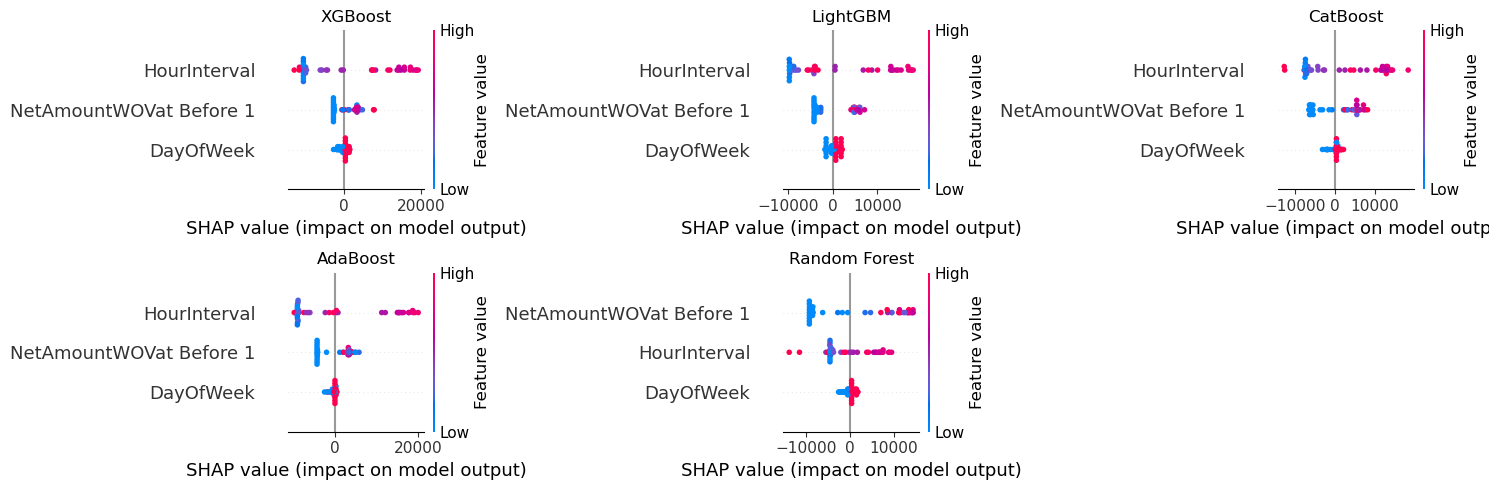

In [45]:
plt.figure(figsize=(15, 5))

plt.subplot(2, 3, 1)
shap.summary_plot(shap_values_xgb_valid, X_valid, plot_size=None, show=False)
plt.title('XGBoost')

plt.subplot(2, 3, 2)
shap.summary_plot(shap_values_lgb_valid, X_valid, plot_size=None, show=False)
plt.title('LightGBM')

plt.subplot(2, 3, 3)
shap.summary_plot(shap_values_cat_valid, X_valid, plot_size=None, show=False)
plt.title('CatBoost')

plt.subplot(2, 3, 4)
shap.summary_plot(shap_values_ada_valid, X_valid, plot_size=None, show=False)
plt.title('AdaBoost')

plt.subplot(2, 3, 5)
shap.summary_plot(shap_values_rf_valid, X_valid, plot_size=None, show=False)
plt.title('Random Forest')

plt.tight_layout()
plt.show()

In [46]:
j = 8
sample = X_valid.iloc[[j]]
print("Features:", sample)
print("Label:", y_valid.iloc[[j]].values)
print("")

shap.initjs()

## XGB
print("XGBoost prediction")
display(shap.force_plot(explainer_xgb.expected_value, shap_values_xgb_valid[j], sample))

## LGB
print("LightGBM prediction")
display(shap.force_plot(explainer_lgb.expected_value, shap_values_lgb_valid[j], sample))

## Cat
print("CatBoost prediction")
display(shap.force_plot(explainer_cat.expected_value, shap_values_cat_valid[j], sample))

## Ada
print("AdaBoost prediction")
display(shap.force_plot(explainer_ada.expected_value, shap_values_ada_valid[j], sample))

## RF
print("Random Forest prediction")
display(shap.force_plot(explainer_rf.expected_value, shap_values_rf_valid[j], sample))

## Ensemble
print("Ensemble prediction")
ensemble_expected = (explainer_xgb.expected_value + explainer_lgb.expected_value + explainer_cat.expected_value + explainer_ada.expected_value + explainer_rf.expected_value) / 5
ensemble_values = (shap_values_xgb_valid[j] + shap_values_lgb_valid[j] + shap_values_cat_valid[j] + shap_values_ada_valid[j] + shap_values_rf_valid[j]) / 5
display(shap.force_plot(ensemble_expected, ensemble_values, sample))

Features:                      HourInterval  DayOfWeek  NetAmountWOVat Before 1
TransactionDateTime                                                  
2024-02-07 14:00:00            14          3                 13332.09
Label: [31310.19]



XGBoost prediction


LightGBM prediction


CatBoost prediction


AdaBoost prediction


Random Forest prediction


Ensemble prediction
